# DAG!

Directed Acyclic Graph

In [1]:
import pandas as pd

import dask.dataframe as dd
from dask.distributed import Client

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:40759 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.23 GB


In [4]:
pdf1 = pd.DataFrame(
    {
        "a": list("asdfgh" * 2),
        "b": range(1, 25, 2),
        "c": [3, 9, 6] * 4,
        "d": ["X", "XX", "X", "XXX"] * 3,
    }
)

In [5]:
pdf1

,a,b,c,d
0,a,1,3,X
1,s,3,9,XX
2,d,5,6,X
3,f,7,3,XXX
4,g,9,9,X
5,h,11,6,XX
6,a,13,3,X
7,s,15,9,XXX
8,d,17,6,X
9,f,19,3,XX


In [6]:
ddf1 = dd.from_pandas(pdf1, npartitions=3)

In [9]:
ddf1

,a,b,c,d
npartitions=3,,,,
0,object,int64,int64,object
4,...,...,...,...
8,...,...,...,...
11,...,...,...,...


In [10]:
pdf1.groupby("d").sum()

,b,c
d,,
X,66,36
XX,33,18
XXX,45,18


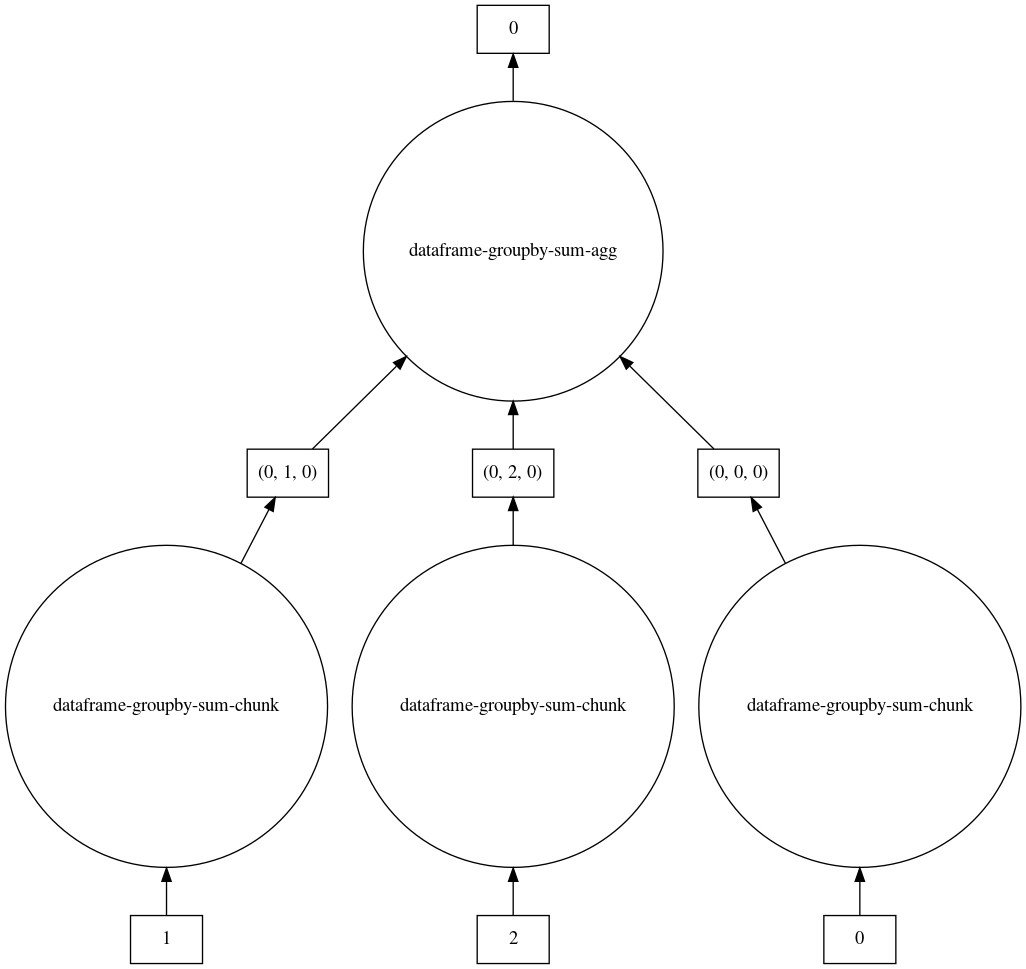

In [16]:
ddf1.groupby("d").sum().visualize()

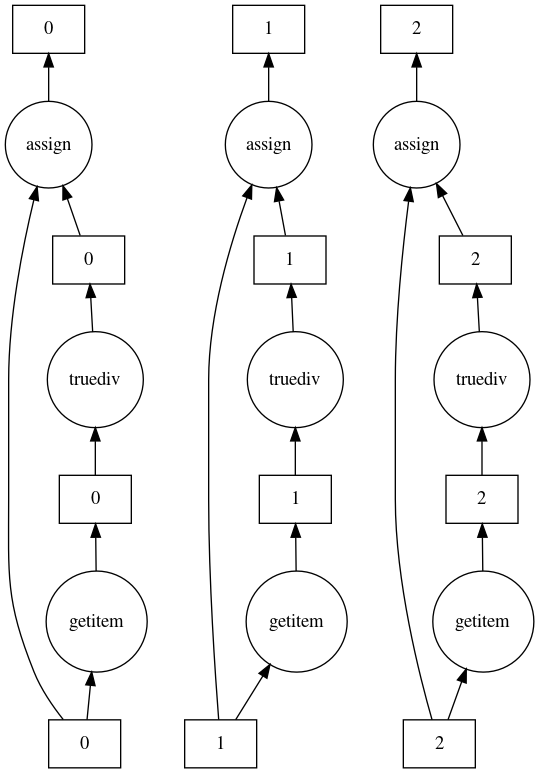

In [21]:
ddf1.assign(e=lambda df: df["c"] / 3).visualize()

In [24]:
ddf1

,a,b,c,d
npartitions=3,,,,
0,object,int64,int64,object
4,...,...,...,...
8,...,...,...,...
11,...,...,...,...


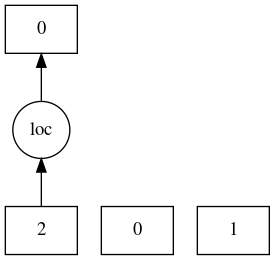

In [27]:
ddf1.loc[8:, :].visualize()

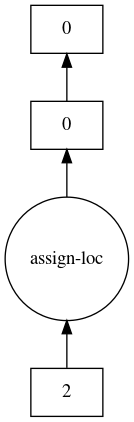

In [35]:
ddf1.assign(e=lambda df: df["c"] / 3).loc[8:, :].visualize(optimize_graph=True)

In [39]:
ddf1.index

Dask Index Structure:
npartitions=3
0     int64
4       ...
8       ...
11      ...
dtype: int64
Dask Name: from_pandas, 6 tasks

In [40]:
ddf1.assign(e=lambda df: df["c"] / 3).loc[8:, :].compute()

,a,b,c,d,e
8,d,17,6,X,2.0
9,f,19,3,XX,1.0
10,g,21,9,X,3.0
11,h,23,6,XXX,2.0


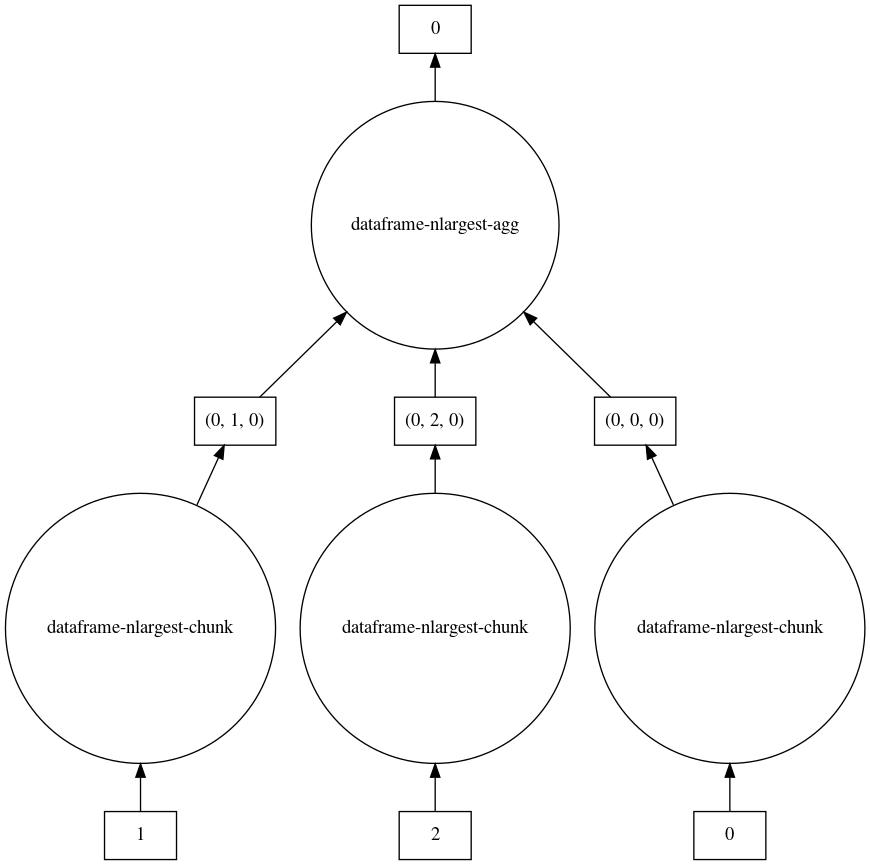

In [42]:
ddf1.nlargest(5, "b").visualize()

- split, apply, combine
- map, reduce
+ divide & conquer

In [53]:
ddf1

,a,b,c,d
npartitions=3,,,,
0,object,int64,int64,object
4,...,...,...,...
8,...,...,...,...
11,...,...,...,...


In [48]:
_ddf = ddf1.categorize("d")

In [55]:
__d = _ddf["d"]

In [67]:
__d.cat.categories

Index(['X', 'XX', 'XXX'], dtype='object', name='d')

In [ ]:
ddf1.pivot_table(
    columns="d", index="a", values="c", aggfunc="mean"
)

In [68]:
ddf1.categorize("d").pivot_table(
    columns="d", index="a", values="c", aggfunc="mean"
).compute()

d,X,XX,XXX
a,,,
a,3.0,NaN,NaN
d,6.0,NaN,NaN
f,NaN,3.0,3.0
g,9.0,NaN,NaN
h,NaN,6.0,6.0
s,NaN,9.0,9.0


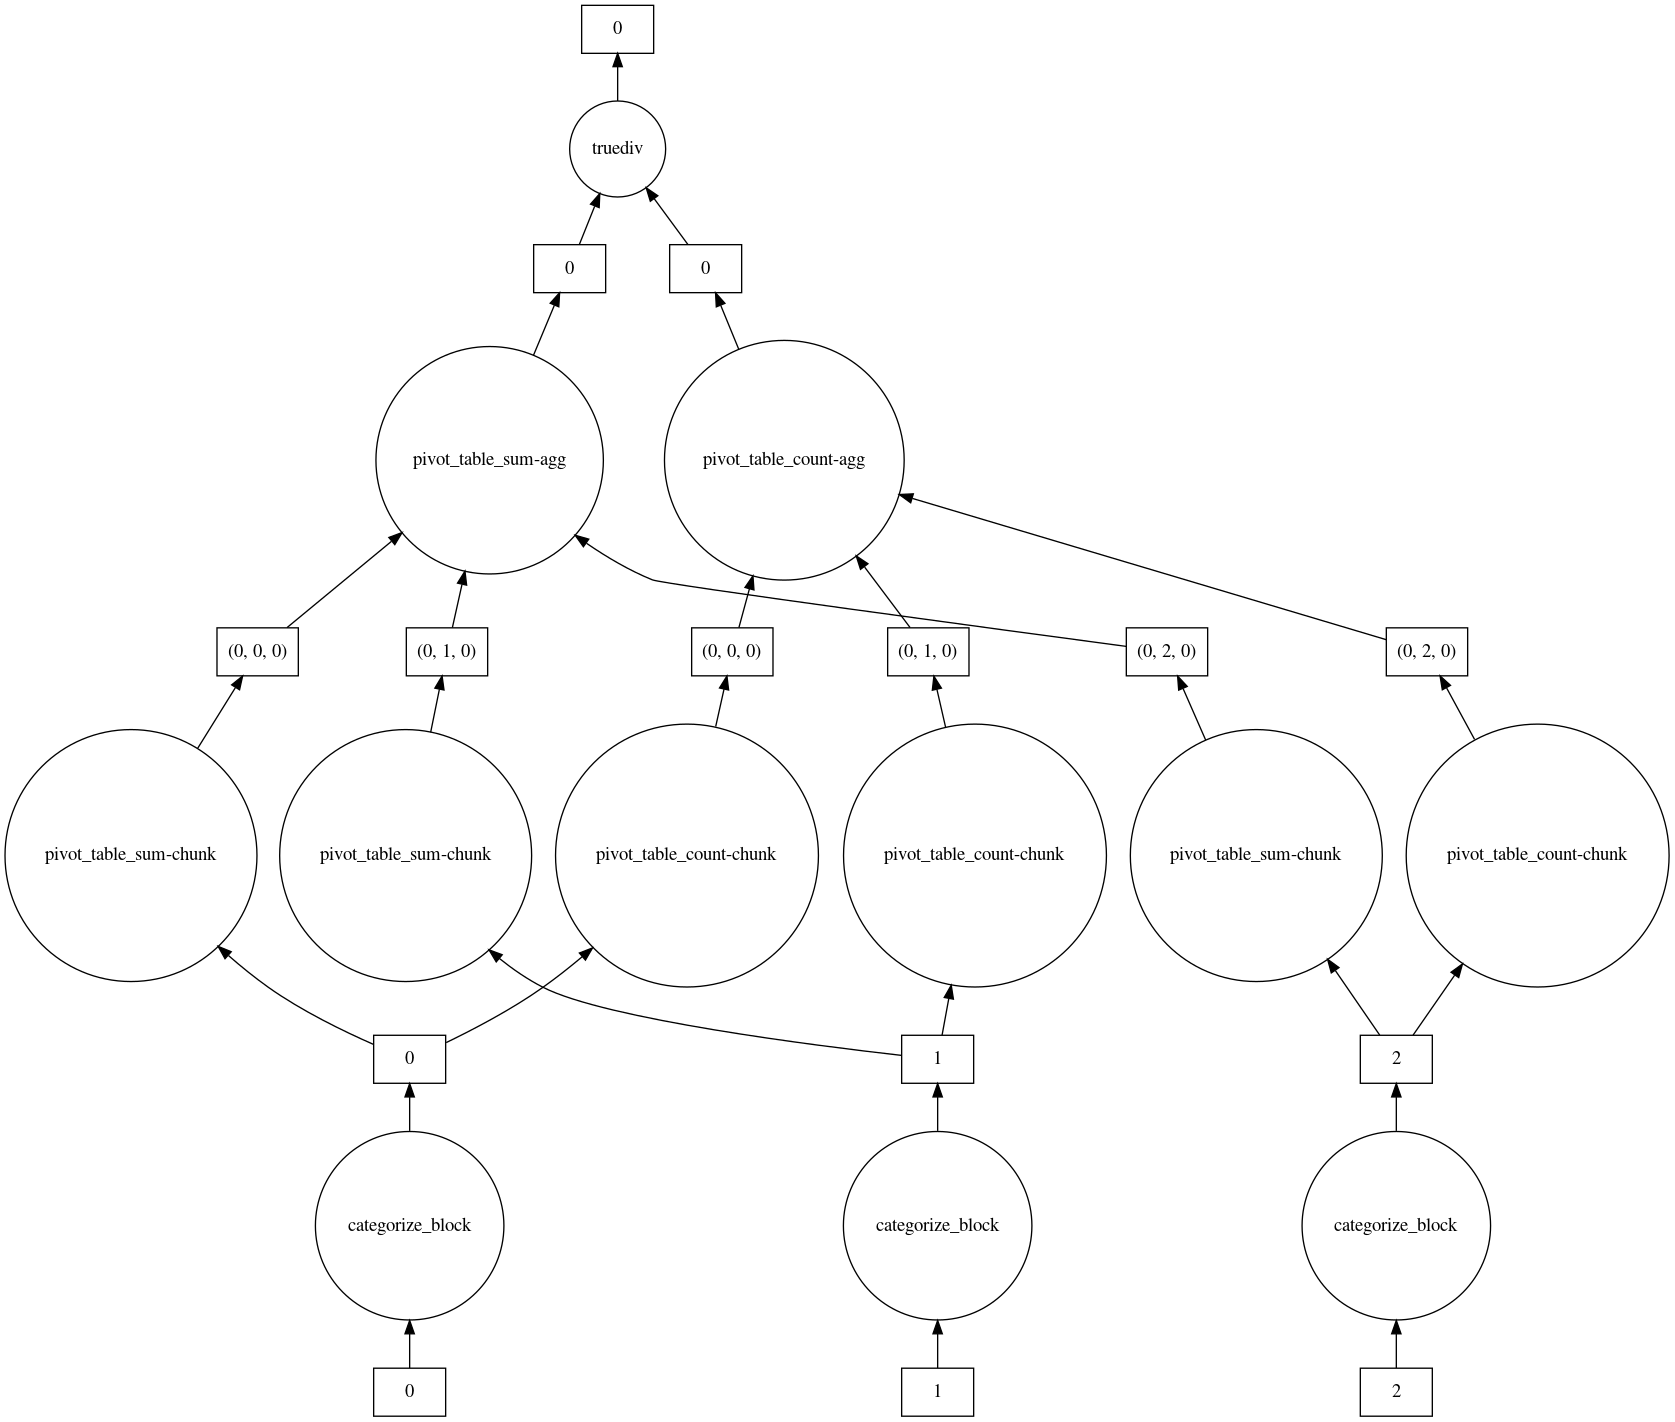

In [71]:
ddf1.categorize("d").pivot_table(
    columns="d", index="a", values="c", aggfunc="mean"
).visualize(optimize_graph=True)

In [84]:
ddf1.groupby("c").apply(lambda df: df, meta=ddf1._meta).compute()#.visualize(optimize_graph=True)

,a,b,c,d
2,d,5,6,X
5,h,11,6,XX
8,d,17,6,X
11,h,23,6,XXX
1,s,3,9,XX
4,g,9,9,X
7,s,15,9,XXX
10,g,21,9,X
0,a,1,3,X
3,f,7,3,XXX


## lots and lots of things missing

- nunique
- sorting
- reindex
- multiindex
- ...

In [91]:
import time

In [92]:
def af(x):
    time.sleep(1)
    return x / 3

In [94]:
%%time
ddf1["c"].apply(af, meta=pd.Series(dtype=float)).compute()

CPU times: user 604 ms, sys: 40.3 ms, total: 645 ms
Wall time: 4.1 s


0     1.0
1     3.0
2     2.0
3     1.0
4     3.0
5     2.0
6     1.0
7     3.0
8     2.0
9     1.0
10    3.0
11    2.0
dtype: float64

In [93]:
%%time
pdf1["c"].apply(af)

CPU times: user 1.4 s, sys: 147 ms, total: 1.55 s
Wall time: 12 s


0     1.0
1     3.0
2     2.0
3     1.0
4     3.0
5     2.0
6     1.0
7     3.0
8     2.0
9     1.0
10    3.0
11    2.0
Name: c, dtype: float64